In [9]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKX4ZIXWV9HTG4JDDTMQ', 'BNb47rETbt7rJwuJxjJb42b3QtIr52TyhESHfogr', api_version='v2')

# Set the ticker symbol and time frame ( XLK - Info Tech )
ticker = "XLB"
timeframe = "1Day"

# Set the start and end dates for the data

start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df['target_close']=df['close']
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [10]:
for index, row in df.iterrows():
    if row["target_close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["target_close"] < 0:
        df.loc[index,"Signal"] = 0.0

# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["target_close"].shift(-1)
#df['RR']=df["RewardRisk"]


df

,close,HH21,LL21,50Pct,61Pct,50R,61R,Mid,RewardRisk,CPctile,OPctile,RangeT,target_close,Signal,FutureSlope
timestamp,,,,,,,,,,,,,,,
2015-12-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023904,0.021739,0.652174,NaN,NaN,0.0,-0.013464
2015-12-02 05:00:00+00:00,-0.013464,NaN,NaN,NaN,NaN,NaN,NaN,-0.003928,0.708333,0.797297,0.148649,NaN,-0.013464,0.0,-0.008805
2015-12-03 05:00:00+00:00,-0.008805,NaN,NaN,NaN,NaN,NaN,NaN,-0.008488,0.968085,0.748663,0.085561,NaN,-0.008805,1.0,0.017544
2015-12-04 05:00:00+00:00,0.017544,NaN,NaN,NaN,NaN,NaN,NaN,0.004474,0.138728,0.126316,0.852632,NaN,0.017544,0.0,-0.017896
2015-12-07 05:00:00+00:00,-0.017896,NaN,NaN,NaN,NaN,NaN,NaN,-0.004729,1.164835,0.731481,0.203704,NaN,-0.017896,0.0,-0.018889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 05:00:00+00:00,0.006925,84.36,76.66,3.85,2.9645,20.394805,26.486760,0.008073,0.495798,0.020202,0.565657,-0.582135,0.006925,1.0,0.000891
2022-12-27 05:00:00+00:00,0.000891,84.36,76.66,3.85,2.9645,20.412987,26.510373,0.008136,0.178914,0.604651,0.465116,-0.803442,0.000891,0.0,-0.015269
2022-12-28 05:00:00+00:00,-0.015269,84.36,76.66,3.85,2.9645,20.101299,26.105583,-0.007372,NaN,0.961039,0.194805,0.475680,-0.015269,1.0,0.010854


In [11]:
df.tail(100)

,close,HH21,LL21,50Pct,61Pct,50R,61R,Mid,RewardRisk,CPctile,OPctile,RangeT,target_close,Signal,FutureSlope
timestamp,,,,,,,,,,,,,,,
2022-08-10 04:00:00+00:00,0.028383,79.80,69.98,4.910,3.78070,16.160896,20.988177,0.024938,-10.823529,0.387931,0.982759,-0.350052,0.028383,1.0,0.003403
2022-08-11 04:00:00+00:00,0.003403,80.63,69.98,5.325,4.10025,14.952113,19.418328,0.010793,-22.500000,0.909910,0.495495,-0.448609,0.003403,1.0,0.018839
2022-08-12 04:00:00+00:00,0.018839,81.14,71.16,4.990,3.84230,16.256513,21.112355,0.004433,0.655022,0.014085,0.894366,0.450377,0.018839,0.0,-0.000616
2022-08-15 04:00:00+00:00,-0.000616,81.19,71.94,4.625,3.56125,17.528649,22.764479,0.001989,0.730594,0.100000,0.775000,-0.106120,-0.000616,1.0,0.005551
2022-08-16 04:00:00+00:00,0.005551,81.87,72.93,4.470,3.44190,18.237136,23.684593,0.009430,-0.255682,0.336538,0.990385,-0.562080,0.005551,0.0,-0.013739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 05:00:00+00:00,0.006925,84.36,76.66,3.850,2.96450,20.394805,26.486760,0.008073,0.495798,0.020202,0.565657,-0.582135,0.006925,1.0,0.000891
2022-12-27 05:00:00+00:00,0.000891,84.36,76.66,3.850,2.96450,20.412987,26.510373,0.008136,0.178914,0.604651,0.465116,-0.803442,0.000891,0.0,-0.015269
2022-12-28 05:00:00+00:00,-0.015269,84.36,76.66,3.850,2.96450,20.101299,26.105583,-0.007372,NaN,0.961039,0.194805,0.475680,-0.015269,1.0,0.010854


In [12]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'target_close', 'Signal',
       'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

,FutureSlope,close
FutureSlope,1.000000,-0.084893
close,-0.084893,1.000000


:Scatter   [HH21]   (FutureSlope)

,FutureSlope,HH21
FutureSlope,1.000000,-0.033956
HH21,-0.033956,1.000000


:Scatter   [LL21]   (FutureSlope)

,FutureSlope,LL21
FutureSlope,1.000000,-0.038432
LL21,-0.038432,1.000000


:Scatter   [50Pct]   (FutureSlope)

,FutureSlope,50Pct
FutureSlope,1.000000,0.004375
50Pct,0.004375,1.000000


:Scatter   [61Pct]   (FutureSlope)

,FutureSlope,61Pct
FutureSlope,1.000000,0.004375
61Pct,0.004375,1.000000


:Scatter   [50R]   (FutureSlope)

,FutureSlope,50R
FutureSlope,1.000000,-0.016909
50R,-0.016909,1.000000


:Scatter   [61R]   (FutureSlope)

,FutureSlope,61R
FutureSlope,1.000000,-0.016909
61R,-0.016909,1.000000


:Scatter   [Mid]   (FutureSlope)

,FutureSlope,Mid
FutureSlope,1.000000,-0.074453
Mid,-0.074453,1.000000


:Scatter   [RewardRisk]   (FutureSlope)

,FutureSlope,RewardRisk
FutureSlope,1.000000,-0.024146
RewardRisk,-0.024146,1.000000


:Scatter   [CPctile]   (FutureSlope)

,FutureSlope,CPctile
FutureSlope,1.000000,0.022921
CPctile,0.022921,1.000000


:Scatter   [OPctile]   (FutureSlope)

,FutureSlope,OPctile
FutureSlope,1.000000,0.024933
OPctile,0.024933,1.000000


:Scatter   [RangeT]   (FutureSlope)

,FutureSlope,RangeT
FutureSlope,1.000000,0.005885
RangeT,0.005885,1.000000


:Scatter   [target_close]   (FutureSlope)

,FutureSlope,target_close
FutureSlope,1.000000,-0.084893
target_close,-0.084893,1.000000


:Scatter   [Signal]   (FutureSlope)

,FutureSlope,Signal
FutureSlope,1.000000,0.690964
Signal,0.690964,1.000000


:Scatter   [FutureSlope]   (FutureSlope)

,FutureSlope,FutureSlope
FutureSlope,1.0,1.0
FutureSlope,1.0,1.0


In [13]:
df=df.dropna()

y = df['Signal']

# Review the value count
y.value_counts()

1.0    935
0.0    817
Name: Signal, dtype: int64

In [14]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=60)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2016-01-13 05:00:00+00:00
2021-01-13 05:00:00+00:00


,50Pct,61Pct,RangeT,OPctile,CPctile
timestamp,,,,,
2016-01-13 05:00:00+00:00,2.9425,2.265725,2.155884,0.060150,0.962406
2016-01-14 05:00:00+00:00,3.0775,2.369675,1.290992,0.582222,0.253333
2016-01-15 05:00:00+00:00,3.3075,2.546775,-0.074045,0.342105,0.342105
2016-01-19 05:00:00+00:00,3.5375,2.723875,2.198541,0.090278,0.659722
2016-01-20 05:00:00+00:00,4.0362,3.107874,2.218587,0.576142,0.209506


,50Pct,61Pct,RangeT,OPctile,CPctile
timestamp,,,,,
2021-01-07 05:00:00+00:00,3.71,2.8567,-0.618079,0.784810,0.645570
2021-01-08 05:00:00+00:00,3.71,2.8567,0.854350,0.045752,0.379085
2021-01-11 05:00:00+00:00,3.71,2.8567,1.151622,0.906977,0.180233
2021-01-12 05:00:00+00:00,3.90,3.0030,0.819047,0.841772,0.170886
2021-01-13 05:00:00+00:00,3.90,3.0030,0.077028,0.148760,0.735537


In [15]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.46      0.12      0.19       241
         1.0       0.51      0.86      0.64       251

    accuracy                           0.50       492
   macro avg       0.48      0.49      0.41       492
weighted avg       0.48      0.50      0.42       492



<AxesSubplot: xlabel='timestamp'>

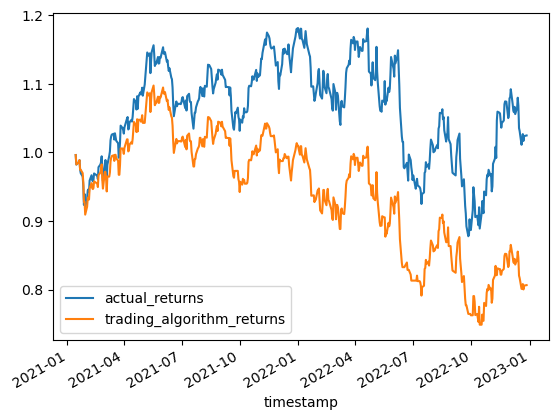

In [16]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["close"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()